In [200]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [201]:
N = 200 # number of points
n = 100 # number of samples/observations
p = 5 # number of variables/features

C = np.random.randint(0, 2, size=(p,p))
r = np.random.multivariate_normal(np.zeros(p), C @ C.T, size=(N, n))

t = np.linspace(0, 1, N)
x = np.cumsum((1/np.sqrt(N))*r, axis=0)

mu = np.mean(x, axis=1, keepdims=True)
x = x - mu

In [202]:
a = 20*t[:, np.newaxis, np.newaxis] + np.random.random((1,n,1)) + 3*np.arange(p)[np.newaxis, np.newaxis, :]
x = (1+np.arange(p)[np.newaxis, np.newaxis, :])*np.sin(a)/2

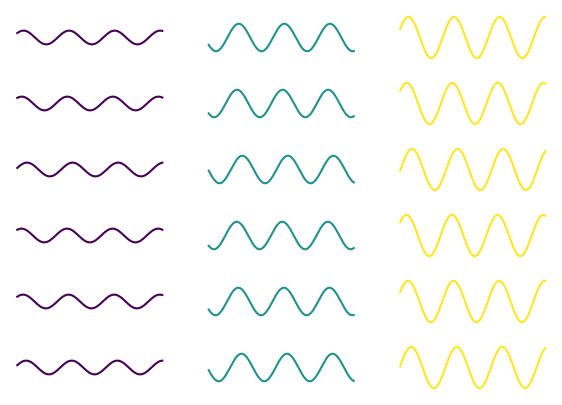

In [203]:
# plot a sample of 6 observations of the first 3 variables
fig, axs = plt.subplots(6, 3, figsize=(7, 5))
cmap = matplotlib.colormaps['viridis'].resampled(3)
for i in range(6):
    for j in range(3):
        ax = axs[i,j]
        ax.plot(t, x[:, i,j], c=cmap(j))
        ax.set_axis_off()
        ax.set_ylim((-2,2))

In [204]:
x_hat = np.fft.fft(x, axis=0)
x_hat.shape

(200, 100, 5)

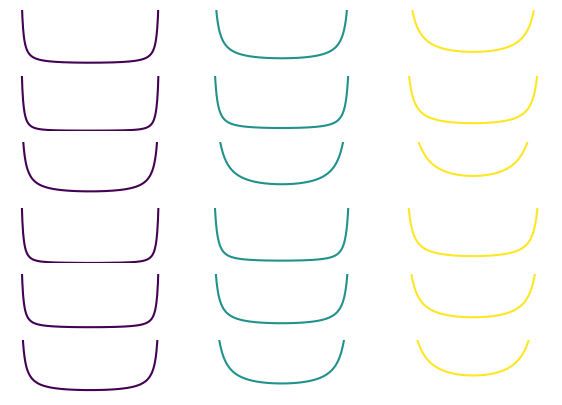

In [205]:
# plot a sample of 6 observations of the first 3 variables
fig, axs = plt.subplots(6, 3, figsize=(7, 5))
cmap = matplotlib.colormaps['viridis'].resampled(3)
for i in range(6):
    for j in range(3):
        ax = axs[i,j]
        ax.plot(t, np.absolute(x_hat[:, i,j]), c=cmap(j))
        ax.set_axis_off()
        ax.set_ylim((0,2))

In [206]:
cov = (x_hat.transpose(0,2,1) @ np.conjugate(x_hat)) / (n-1)

In [207]:
eigenvalues, eigenvectors = np.linalg.eigh(cov)
# Order the eigenvalues and eigenvectors by descending order
idx = np.argsort(eigenvalues, axis=1)[:, ::-1]
eigenvalues = np.take_along_axis(eigenvalues, idx, axis=-1)
eigenvectors = np.take_along_axis(eigenvectors, idx[:,np.newaxis,:], axis=-1)

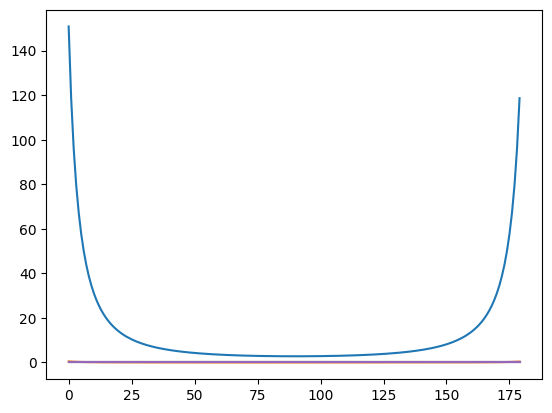

In [208]:
plt.plot(eigenvalues[10:-10])
plt.show()

In [209]:
# select correctly the sign of the eigenvectors
#for i in range(1, eigenvectors.shape[0]):
#    eigenvectors[i] *= np.sign(np.sum(eigenvectors[i] * eigenvectors[i-1], axis=0, keepdims=True))

In [210]:
eigenvectors_hat = np.fft.ifft(eigenvectors, axis=0)

In [211]:
k=1

x_complex = x.astype(np.complex128)
Z = np.zeros((N, n, k), dtype=np.complex128)
for _n in range(n):
    for _p in range(p):
        for _k in range(k):
            Z[:, _n, _k] +=np.convolve(x_complex[:, _n, _p], eigenvectors_hat[:, _p, _k], mode="same")

In [212]:
y = np.zeros((N, n, p), dtype=np.complex128)
for _n in range(n):
    for _p in range(p):
        for _k in range(k):
            y[:, _n, _p] += np.convolve(Z[:, _n, _k], eigenvectors_hat[:, _k, _p], mode="same")

In [213]:
print("Mean Square Error ", np.mean(np.square(np.absolute(y - x))))

Mean Square Error  1.9434360128361199


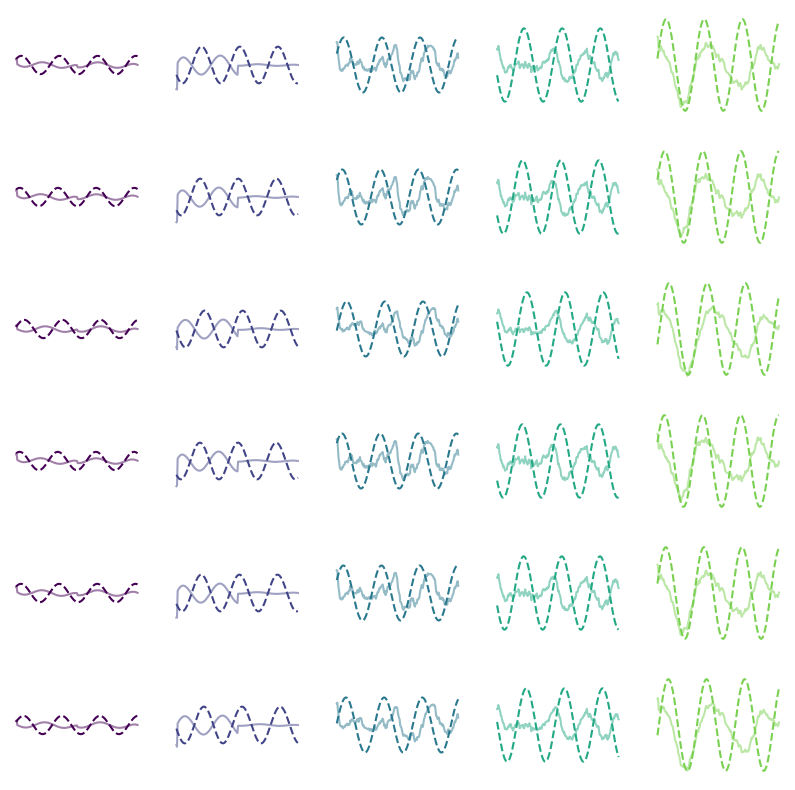

In [214]:
# plot a sample of n_r observations of the first n_c variables
n_r, n_c = 6, 5
fig, axs = plt.subplots(n_r, n_c, figsize=(10, 10))
cmap = matplotlib.colormaps['viridis'].resampled(n_c+1)
for i in range(n_r):
    for j in range(n_c):
        ax = axs[i,j]
        ax.plot(t, x[:, i,j], c=cmap(j), linestyle='dashed')
        ax.plot(t, y[:, i,j], c=cmap(j), alpha=0.5)
        ax.set_axis_off()
        ax.set_ylim((-3,3))

In [227]:
k=2
Z = x_hat @ eigenvectors[:, :, :k]
x_norm_hat = Z @ eigenvectors[:, :, :k].transpose(0,2,1).conjugate()

In [228]:
x_norm_hat_hat = np.fft.ifft(x_norm_hat, axis=0)

In [229]:
print("Mean Square Error ", np.mean(np.square(x_hat - x_norm_hat)))

Mean Square Error  (2.954524035538483e-23+1.1558530568248389e-22j)


In [230]:
print("Mean Square Error ", np.mean(np.square(np.absolute(x - x_norm_hat_hat))))

Mean Square Error  1.0641669966262441e-24


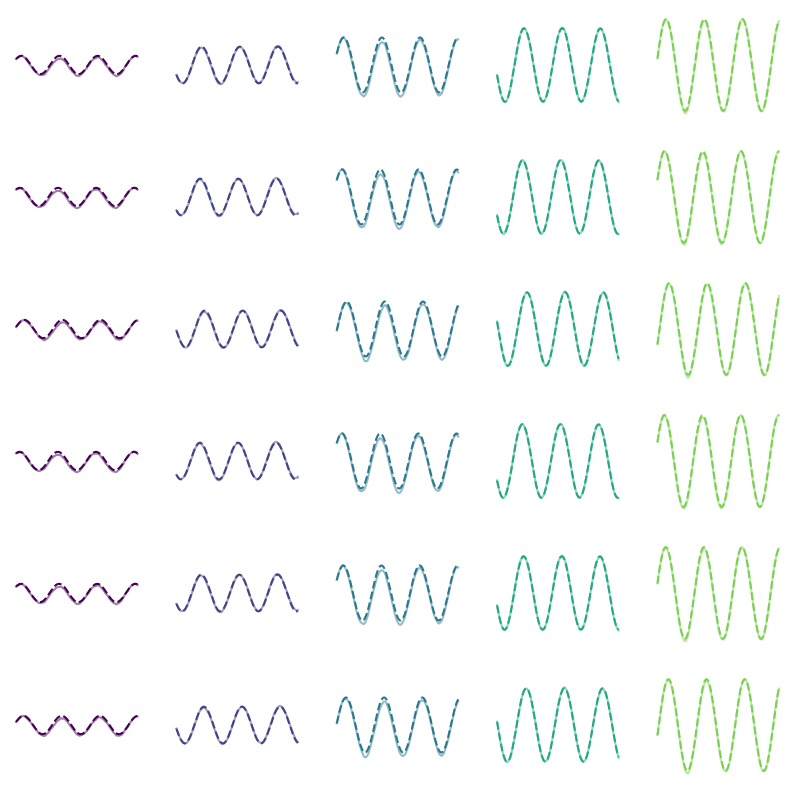

In [231]:
# plot a sample of n_r observations of the first n_c variables
n_r, n_c = 6, 5
fig, axs = plt.subplots(n_r, n_c, figsize=(10, 10))
cmap = matplotlib.colormaps['viridis'].resampled(n_c+1)
for i in range(n_r):
    for j in range(n_c):
        ax = axs[i,j]
        ax.plot(t, x[:, i,j], c=cmap(j), linestyle='dashed')
        ax.plot(t, x_norm_hat_hat[:, i,j].real + mu[:, 0, j], c=cmap(j), alpha=0.5)
        ax.set_axis_off()
        ax.set_ylim((-3,3))